In [243]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
import sys
sys.path.insert(0, "/home/gh464/Documents/GitHub/SyMBac/") 
from SyMBac.drawing import raster_cell, OPL_to_FL, convert_to_3D
import matplotlib.pyplot as plt
import numpy as np
from skimage.morphology import dilation, disk
from skimage.measure import label
from joblib import Parallel, delayed
from tqdm.auto import tqdm
import seaborn as sns
import pandas as pd
from SyMBac.drawing import raster_cell, OPL_to_FL
from SyMBac.PSF import PSF_generator
from SyMBac.renderer import convolve_rescale
from SyMBac.PSF import PSF_generator
import tifffile
from skimage.util import img_as_uint
from skimage.transform import resize
import os
from skimage.draw import disk

In [2]:
pixel_size = 0.05
scale = 1
pixel_size = pixel_size/scale
def simulate_molecule_counting(N_molecules, length, width):
    OPL_cell = raster_cell(length/pixel_size,width/pixel_size,separation=False)
    volume = np.sum(OPL_cell)
    density = N_molecules/volume
    FL_cell = OPL_to_FL(OPL_cell, density = density)
    true_N_molecules = np.sum(FL_cell)
    return FL_cell, true_N_molecules

In [3]:
length = 5
width = 1
OPL_cell = raster_cell(length/pixel_size,width/pixel_size,separation=False)

In [4]:
OPL_cell_3D = convert_to_3D(OPL_cell)
OPL_cell_3D = np.pad(OPL_cell_3D, ((0,0),(10,10),(10,10)))

In [5]:
my_kernel = PSF_generator(
    radius = 30, 
    wavelength = 0.55, 
    NA=1.49, 
    n = 1.518, 
    resize_amount=1, 
    pix_mic_conv=pixel_size, 
    apo_sigma = 10, 
    mode="3d fluo", 
    condenser="Ph3", 
    z_height = OPL_cell_3D.shape[0],
    pz = 0.5,
    working_distance = 170
)
my_kernel.calculate_PSF()
my_kernel.kernel /= np.sum(my_kernel.kernel)

(18, 120, 40)


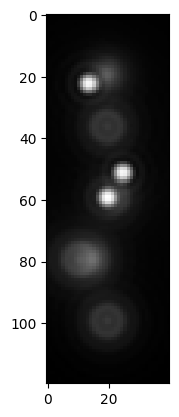

In [290]:
FL_cell_3D = np.zeros_like(OPL_cell_3D).astype(np.float32)
print(FL_cell_3D.shape)

FL_cell_3D[9,60,20] = 1
FL_cell_3D[9,23,14] = 1
FL_cell_3D[9,52,25] = 1



FL_cell_3D[2,20,20] = 1
FL_cell_3D[2,80,15] = 1
FL_cell_3D[2,60,22] = 1

FL_cell_3D[17,100,20] = 1
FL_cell_3D[17,80,11] = 1
FL_cell_3D[17,37,20] = 1


localisation_data = pd.DataFrame(np.argwhere(FL_cell_3D)[:,1:] * (pixel_size * 1000))
localisation_data.columns = ["y [nm]", "x [nm]"]
localisation_data["Photon #"] = 2250

conv_FL_cell_3D = np.array([convolve_rescale(cell_layer, PSF_layer, 1, False) for cell_layer, PSF_layer in zip(FL_cell_3D, my_kernel.kernel)])


conv_FL_cell = conv_FL_cell_3D.sum(axis=0)

conv_FL_cell = conv_FL_cell/(conv_FL_cell.max())
conv_FL_cell = img_as_uint(conv_FL_cell)
plt.imshow(conv_FL_cell**0.7, cmap="Greys_r")



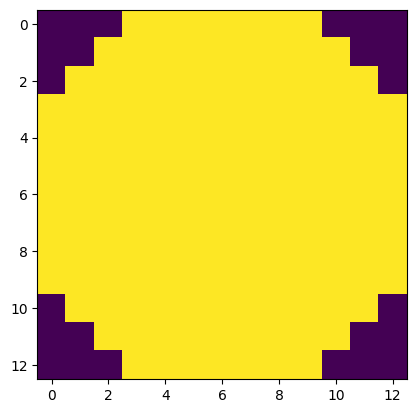

In [307]:
circle = np.zeros((13,13))
rr, cc = disk((6, 6), 7, shape=(13,13))
circle[rr,cc] = 1
plt.imshow(circle)

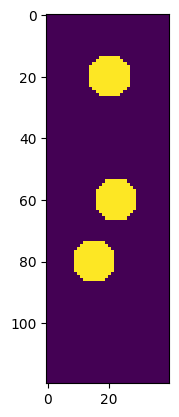

In [278]:
top_layer = dilation(FL_cell_3D[2,:,:], circle)
plt.imshow(top_layer)

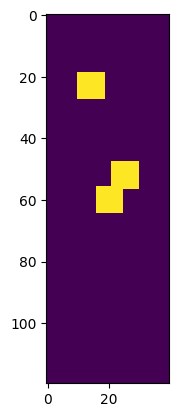

In [279]:
middle_layer = dilation(FL_cell_3D[9,:,:], np.ones((9,9)))
plt.imshow(middle_layer)

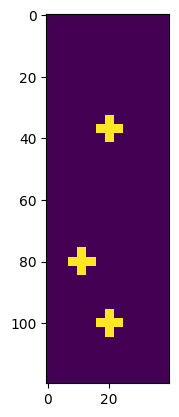

In [280]:
cross = np.zeros((9,9))
cross[:,3:6] = 1
cross[3:6,:] = 1

bottom_layer = dilation(FL_cell_3D[17,:,:], cross)
plt.imshow(bottom_layer)

In [281]:
xx, yy = np.meshgrid(np.linspace(0,conv_FL_cell.shape[1],conv_FL_cell.shape[1]), np.linspace(0,conv_FL_cell.shape[0],conv_FL_cell.shape[0]))
#xx, yy = xx*conv_FL_cell, yy*conv_FL_cell
Z =  10*np.ones(xx.shape)

[]

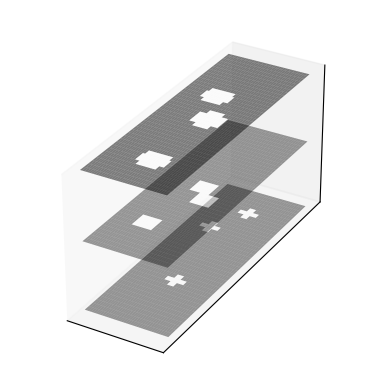

In [306]:
import matplotlib.pyplot as plt
import numpy as np


ax = plt.figure().add_subplot(projection='3d')
ax.grid(False)
Z =  1*np.ones(xx.shape)
ax.plot_surface(xx, yy, Z, facecolors=plt.cm.gray(top_layer), shade=False, alpha=0.5, linewidth=0)
Z =  0*np.ones(xx.shape)
ax.plot_surface(xx, yy, Z, facecolors=plt.cm.gray(middle_layer), shade=False, alpha=0.4, linewidth=0)
Z =  -1*np.ones(xx.shape)
ax.plot_surface(xx, yy, Z, facecolors=plt.cm.gray(bottom_layer), shade=False, alpha=0.4, linewidth=0)

ax.set_box_aspect((np.ptp(xx), np.ptp(yy), np.ptp(yy)*0.5)) 
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])


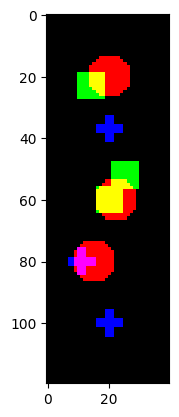

In [288]:
layers_RGB = np.zeros(top_layer.shape + (3,))
layers_RGB[:,:,0] = top_layer
layers_RGB[:,:,1] = middle_layer
layers_RGB[:,:,2] = bottom_layer
plt.imshow(layers_RGB)

In [287]:
layers_RGB.shape

(120, 40, 3)